In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import xgboost as xgb
from xgboost import plot_importance, plot_tree, to_graphviz

import utility_functions as fn

In [2]:
energy = pd.read_csv('data/elec_clean.csv',index_col=0)
energy.index = pd.to_datetime(energy.index,format='%Y-%m-%d %H:00:00')

# removing Davenport for now because it is missing most of June and July
energy.drop('Davenport',axis=1,inplace=True)

energy['Yale']= energy.iloc[:, 0:11].sum(axis=1)
energy = pd.DataFrame(energy['Yale'])

In [3]:
weather = pd.read_csv('data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')

weather = fn.add_hours_before(weather,np.arange(1,24))
weather = weather.loc[energy.index[0]:energy.index[len(energy)-1]]

In [4]:
# dates = pd.read_csv('one_hot_dates.csv',index_col=0)
# dates.index = pd.to_datetime(dates.index,format='%Y-%m-%d %H:00:00')
# dates = dates.loc[energy.index[0]:energy.index[len(energy)-1]]
dates = fn.date_features(energy)

In [29]:
split_date = '2018-01-08 00:00:00'

y_train = energy.loc[energy.index <= split_date].copy()
y_test = energy.loc[energy.index > split_date].copy()

In [30]:
weather_train = weather.loc[weather.index <= split_date].copy()
weather_test = weather.loc[weather.index > split_date].copy()

dates_train = dates.loc[dates.index <= split_date].copy()
dates_test = dates.loc[dates.index > split_date].copy()

X_train = weather_train.join(dates_train)
X_test = weather_test.join(dates_test)

In [31]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

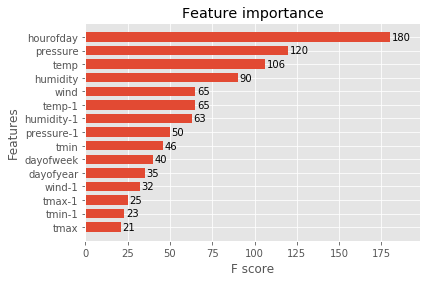

In [32]:
_ = plot_importance(reg, height=0.7,max_num_features=15)

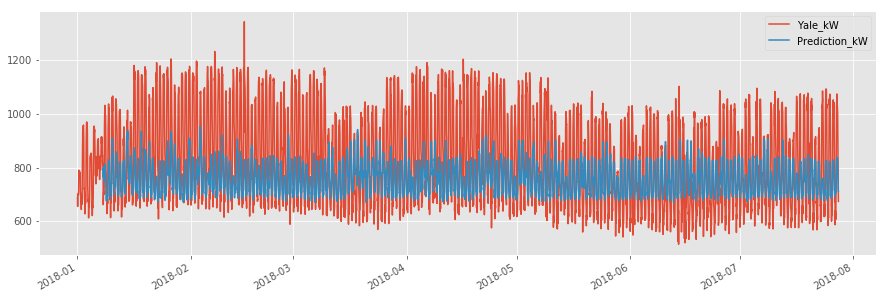

In [33]:
y_test['Prediction'] = reg.predict(X_test)
yale_all = pd.concat([y_test, y_train], sort=False)
_ = yale_all[['Yale','Prediction']].plot(figsize=(15, 5))

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mean_absolute_percentage_error(y_true=y_test['Yale'], y_pred=y_test['Prediction']).round(2)


12.89

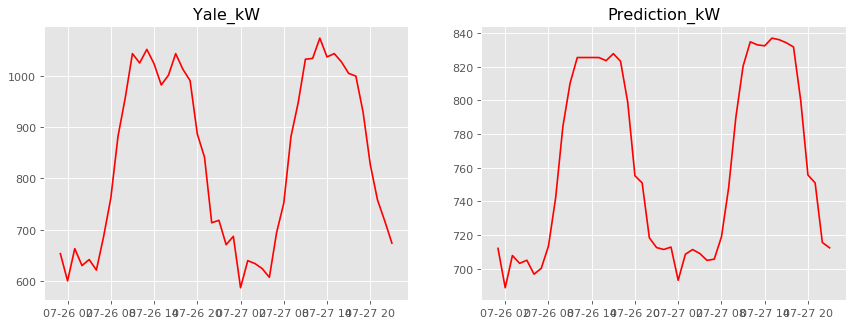

In [36]:
fn.plot_all(y_test,'2018-07-26 01:00:00','2018-07-27 23:00:00')